# Supervised Variational Auto Encoder - Version 1

In [251]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam

In [252]:
import matplotlib.pyplot as plt

In [414]:
pyro.__version__

'0.4.1'

In [331]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [403]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=True):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [404]:
class EncoderZ(nn.Module):
    #def __init__(self, z_dim, hidden_dim):
    def __init__(self, x_dim, y_dim, h_dim, z_dim):
        super(EncoderZ, self).__init__()
        # setup the three linear transformations used
        #have to here define the fully connected layers - 784 to 400
        #400 to 2
        
        # setup the non-linearities
        self.fc1 = nn.Linear(x_dim+y_dim, h_dim)  
        self.fc21 = nn.Linear(h_dim, z_dim) 
        self.fc22 = nn.Linear(h_dim, z_dim)
        
        self.softplus = nn.Softplus()

    def forward(self, x_y_2):
        [x,y]=x_y_2
        x = x.reshape(-1, 784) #@David Change this to reshape if something fucks up
        y = y.reshape(-1, 10) #@David Change this to reshape if something fucks up
        x_y_1 = torch.cat((x,y), dim=1) #I think that this should concatenate the two inputs if this does work then test it independenlty
        x_y_1 = x_y_1.view(x_y_1.size(0), -1)
        
        hidden = self.softplus(self.fc1(x_y_1))
        
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden)) # mu, log_var
        return z_loc, z_scale

In [405]:
class Decoder(nn.Module):
    def __init__(self, x_dim, y_dim, h_dim, z_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim+y_dim, h_dim)
        self.fc21 = nn.Linear(h_dim, x_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self,z_y_2):
        # define the forward computation on the latent z
        # first compute the hidden units
        
        [z,y]=z_y_2
        
        z = z.reshape(-1, 2) #@David Change this to reshape if something fucks up
        y = y.reshape(-1, 10)
        z_y_1 = torch.cat((z,y), dim=1)
        z_y_1 = z_y_1.view(z_y_1.size(0), -1)
        hidden = self.softplus(self.fc1(z_y_1))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [406]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, x_dim = 784, y_dim = 10, h_dim = 500, z_dim = 2,use_cuda=True):
        super(VAE, self).__init__()
    
        # create the encoder and decoder networks
        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim,z_dim]
        # to produce loc and scale, and apply different activations [None,Exp] on them
              
        self.encoder_z = EncoderZ(x_dim, y_dim, h_dim, z_dim)
        
        self.decoder = Decoder(x_dim, y_dim, h_dim, z_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
            
            
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.output_size = y_dim
        
        
    # define the model p(x|z)p(z)
    def model(self, xs, ys):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)
        batch_size = xs.size(0)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):

            # sample the handwriting style from the constant prior distribution
            prior_loc = xs.new_zeros([batch_size, self.z_dim])
            prior_scale = xs.new_ones([batch_size, self.z_dim])
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = xs.new_ones([batch_size, self.output_size]) / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)
            
            # finally, score the image (x) using the handwriting style (z) and
            # the class label y (which digit to write) against the
            # parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            # where `decoder` is a neural network
            loc = self.decoder.forward([zs, ys])
            pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
            
    def guide(self, xs, ys):
        with pyro.plate("data"):
           # if the class label (the digit) is not supervised, sample
           # (and score) the digit with the variational distribution
           # q(y|x) = categorical(alpha(x))
           
            #-------------------REMOVED THIS PART FOR THE CLASSIFIER ASSUME ALL DATA ARE LABELLED---------

           # sample (and score) the latent handwriting-style with the variational
           # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
           loc, scale = self.encoder_z.forward([xs, ys])
           pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, xs, ys):
        # encode image x
        z_loc, z_scale = self.encoder_z.forward([xs,ys])
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder.forward([zs,ys])
        
        return loc_img

In [410]:
def train(svi, train_loader, use_cuda=True):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        labels_y = torch.tensor(np.zeros((y.shape[0],10)))
        for j in range (0,y.shape[0]):
            labels_y[j,int(y[j].numpy())] = 1
        epoch_loss += svi.step(x.reshape(-1,784),labels_y.float())

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [419]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 50
TEST_FREQUENCY = 5

In [420]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_params = {"lr": 0.0003}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi_aux = SVI(model_classify, guide_classify, optimizer, loss=Trace_ELBO())

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())


train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 216.9260
[epoch 001]  average training loss: 179.4542
[epoch 002]  average training loss: 171.1694
[epoch 003]  average training loss: 165.3247
[epoch 004]  average training loss: 161.0235
[epoch 005]  average training loss: 158.2552
[epoch 006]  average training loss: 156.2076
[epoch 007]  average training loss: 154.4524
[epoch 008]  average training loss: 152.7730
[epoch 009]  average training loss: 151.2435
[epoch 010]  average training loss: 149.9963
[epoch 011]  average training loss: 148.9709
[epoch 012]  average training loss: 148.1016
[epoch 013]  average training loss: 147.3774
[epoch 014]  average training loss: 146.7372
[epoch 015]  average training loss: 146.1686
[epoch 016]  average training loss: 145.6654
[epoch 017]  average training loss: 145.2398
[epoch 018]  average training loss: 144.8295
[epoch 019]  average training loss: 144.4458
[epoch 020]  average training loss: 144.1104
[epoch 021]  average training loss: 143.7935
[epoch 022

In [369]:
def single_image_sampler(z0=0.0,z1=0.0, z2=0.0, z3=0.0, z4=0.0, z5=0.0, z6=0.0, z7=0.0, z8=0.0, z9=0.0):
    z = torch.rand(1,10)
    z[0,0]=z0
    z[0,1]=z1
    z[0,2]=z2
    z[0,3]=z3
    z[0,4]=z4
    z[0,5]=z5   
    z[0,6]=z6
    z[0,7]=z7    
    z[0,8]=z8
    z[0,9]=z9
    labels_y = torch.tensor(np.zeros((10)))
    labels_y[0] = 1
    single_sample_image = vae.decoder([z,labels_y.float()])
    image_array_single =single_sample_image.reshape(28,28).cpu().detach().numpy()
    temp_array=image_array_single
  #  plt.figure(figsize = (10,10))
  #  plt.imshow(image_array_single)
 #   plt.colorbar()
 #   plt.show() 
    return image_array_single

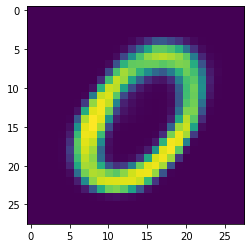

In [370]:
rand_0 = np.random.uniform(-2,2)
rand_1 = np.random.uniform(-2,2)
rand_2 = np.random.uniform(-0.5,0.5)
rand_3 = np.random.uniform(-0.2,0.4)
rand_4 = np.random.uniform(-1,1)
rand_5 = np.random.uniform(-0.1,0.1)
rand_6 = np.random.uniform(-0.1,0.2)
rand_7 = np.random.uniform(-2.3,2.5)
rand_8 = np.random.uniform(-0.2,0.2)
rand_9 = np.random.uniform(-0.2,0.2)
image = single_image_sampler(rand_0,rand_1,rand_2,rand_3,rand_4,rand_5,rand_6,rand_7,rand_8,rand_9)
img_max = image.max() 
plt.imshow(image)
plt.show()

In [418]:
from torchvision.utils import save_image
number=9
with torch.no_grad():
    count = 0
    z = torch.randn(100, 2)
    labels_y = torch.tensor(np.zeros((100,10)))
    for i in range (0,10):
        for j in range (0,10):
            z[count,0]=np.random.uniform(-2,2)
            z[count,1]=np.random.uniform(-2,2)
            labels_y[count,8] = 1
            labels_y[count,0] = 1
            count = count +1 
        
    sample = vae.decoder([z,labels_y.float()])
    
    save_image(sample.view(100, 1, 28, 28), str(number)+'_sample_z_space_' +str(epoch)+'.png',nrow=10)